# Path Integral Ground State QMC for the Harmonic Oscillator

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
try: plt.style.use('./notebook.mplstyle')
except: pass

π = np.pi
red,blue,green = '#e85c47','#4173b2','#7dcca4'

## Hamiltonian

\begin{equation}
\hat{H} = -\lambda \frac{d^2}{dx^2} + \frac{1}{4\lambda} \left(\frac{\hbar \omega}{k_{\rm B}}\right)^2 x^2
\end{equation}

where $\lambda = \hbar^2/2m$.

In [14]:
class Paths:
    '''The set of worldlines, action and estimators.'''
    def __init__(self,beads,M,Δτ,λ):
        self.Δτ = Δτ
        self.λ = λ
        self.beads = np.copy(beads)
        self.M = M
        self.num_time_slices = beads.shape[0]
        self.N = beads.shape[1]
        self.norm = np.ones(self.num_time_slices)
        
        self.norm[0] = self.norm[-1] = 0.5
        
    def V(self,x):
        '''harmonic oscillator potential'''
        ω = 1.0
        return ω*ω*x*x /(4.0*self.λ)
    
    def Ψ(self,x):
        '''trial wave function'''
        return 1.0
    
    def kinetic_action(self,α,i):
        '''kinetic action of a bead.'''
        
        if α == 0.0:
            cK = (self.beads[α+1,i]-self.beads[α,i])**2
        elif α == 2*self.M:
            cK = (self.beads[α,i]-self.beads[α-1,i])**2
        else:
            cK = (self.beads[α,i]-self.beads[α-1,i])**2\
                 + (self.beads[α+1,i]-self.beads[α,i])**2
        return cK / (4*self.λ*self.Δτ)

    def potential_action(self,α):
        '''potential action of a slice.'''
        cV = 0.0
        ΨT = 1.0
            
        for i in range(self.N):
            x = self.beads[α,i]
            cV += self.norm[α]*self.V(x)
            
            # add the wavefunction at the ends of the path
            if α == 0 or α == 2*self.M:
                ΨT *= self.Ψ(x)
                
        return self.Δτ*cV - np.log(ΨT)

    def Energy(self):
        '''The total energy.'''
                
        # the kinetic part
        norm = 1.0/(4.0*self.λ*self.Δτ**2)
        KE = 0.0
        for α in range(2*self.M):
            for i in range(self.N):
                ΔR = self.beads[α+1,i] - self.beads[α,i]
                KE += 0.5*self.N/self.Δτ - norm*np.dot(ΔR,ΔR)
        
        KE /= 2*self.M
        
        # the potential part
        PE = 0.0
        Vslice = np.zeros(self.num_time_slices)
        for α in range(2*self.M+1):
            for i in range(self.N):
                cV = self.V(self.beads[α,i])
                Vslice[α] += cV
                PE += self.norm[α]*cV
        
        PE /= 2*self.M
        
        return KE + PE, Vslice

In [21]:
def displace(Path,α,i,δ=0.75):
    '''Single bead displace update.
    
       NB: not implemented for periodic boundary conditions.
    '''
    # Calculate the action
    x = Path.beads[α,i]
    oldAction = Path.kinetic_action(α,i) + Path.potential_action(α)

    # Displace the bead
    Path.beads[α,i] += δ*(-1.0 + 2.0*np.random.random())

    # Compute the new action
    newAction = Path.kinetic_action(α,i) + Path.potential_action(α)
    
    # Accept the move, or reject and restore the bead position
    if np.random.random() < np.exp(-(newAction - oldAction)):
        return True
    else:
        Path.beads[α,i] = x
        return False

In [20]:
def staging(Path,m,i):
    '''Multi-slice update which eactly samples the free particle 
       propagator between two fixed beads.

       See: http://link.aps.org/doi/10.1103/PhysRevB.31.4234
    
       NB: not implemented for periodic boundary conditions.
    '''
    # choose the start and end of the stage
    α_start = np.random.randint(low=0,high=Path.num_time_slices)
    α_end = α_start + m
    
    # if we move off the end of the path, reject the move
    if α_end >= Path.num_time_slices:
        return False

    # Record the positions of the beads to be updated and store the action
    x = np.copy(Path.beads[α_start+1:α_end,i])
    oldAction = 0.0
    for α in range(α_start+1,α_end):
        oldAction += Path.potential_action(α)

    # Generate new positions and accumulate the new action
    newAction = 0.0;
    for α in range(α_start+1,α_end):
        Δτ1 = Path.Δτ   
        Δτ2 = (α_end - α)*Path.Δτ
        avex = (Δτ2*Path.beads[α-1,i] + Δτ1*Path.beads[α_end,i])\
                / (Δτ1 + Δτ2)
        σ = np.sqrt(2.0*Path.λ / (1.0/Δτ1 + 1.0/Δτ2))
        Path.beads[α,i] = np.random.normal(loc=avex,scale=σ)
        newAction += Path.potential_action(α)

    # Perform the Metropolis step, if we reject, revert the worldline
    if np.random.random() < np.exp(-(newAction - oldAction)):
        return True
    else:
        Path.beads[α_start+1:α_end,i] = x
        return False

In [18]:
def pigs(num_MC_steps,num_equil_steps,Path,m=8):
    '''Perform a path integral ground state Monte Carlo simulation.'''

    # initialize estimators and acceptance counters
    numAccept = {'displace':0,'staging':0}
    estimator = {'E':np.zeros(num_MC_steps-num_equil_steps),
                 'Vslice':np.zeros([num_MC_steps-num_equil_steps,Path.num_time_slices])}

    measure = 0
    for step in range(num_MC_steps): 
        
        # for each particle and slice try a displace move
        for α in range(Path.num_time_slices):
            for i in range(Path.N):
                numAccept['displace'] += displace(Path,α,i)

        # for each particle try a number of staging moves
        num_stage = int(Path.num_time_slices/m)
        for stage in range(num_stage):
            for i in range(Path.N): 
                numAccept['staging'] += staging(Path,m,i)

        # measure the energy
        if step >= num_equil_steps:
            measure = step-num_equil_steps
            estimator['E'][measure],estimator['Vslice'][measure] = Path.Energy()
                     
    print('displace: %4.3f' %
          ((1.0*numAccept['displace'])/(num_MC_steps*Path.num_time_slices*Path.N)))
    print('staging:  %4.3f' %
          ((1.0*numAccept['staging'])/(num_MC_steps*Path.N*num_stage)))
    
    return estimator

## Perform the PIGS Simulation

In [22]:
# setup the simulation
M,N,τ,λ = 10,1,4.0,0.5
Δτ = τ/M

# random initial positions
np.random.seed(1173)
beads = -0.5 + np.random.random([2*M+1,N])

# setup the paths
Path = Paths(beads,M,Δτ,λ)

# compute the energy via path integral ground state Monte Carlo
num_MC_steps = 10000
num_equil_steps = 1000
estimator = pigs(num_MC_steps,num_equil_steps,Path)

displace: 0.681
staging:  0.406


## Compute the averages and their standard error

In [23]:
from scipy.stats import sem
Ē,ΔĒ = np.average(estimator['E']),sem(estimator['E'])
V̄slice,ΔV̄slice = np.average(estimator['Vslice'],axis=0),sem(estimator['Vslice'],axis=0)

print('Ē = %f ± %f' % (Ē,ΔĒ))

Ē = 0.490717 ± 0.003394


## Plot the potential energy on each slice

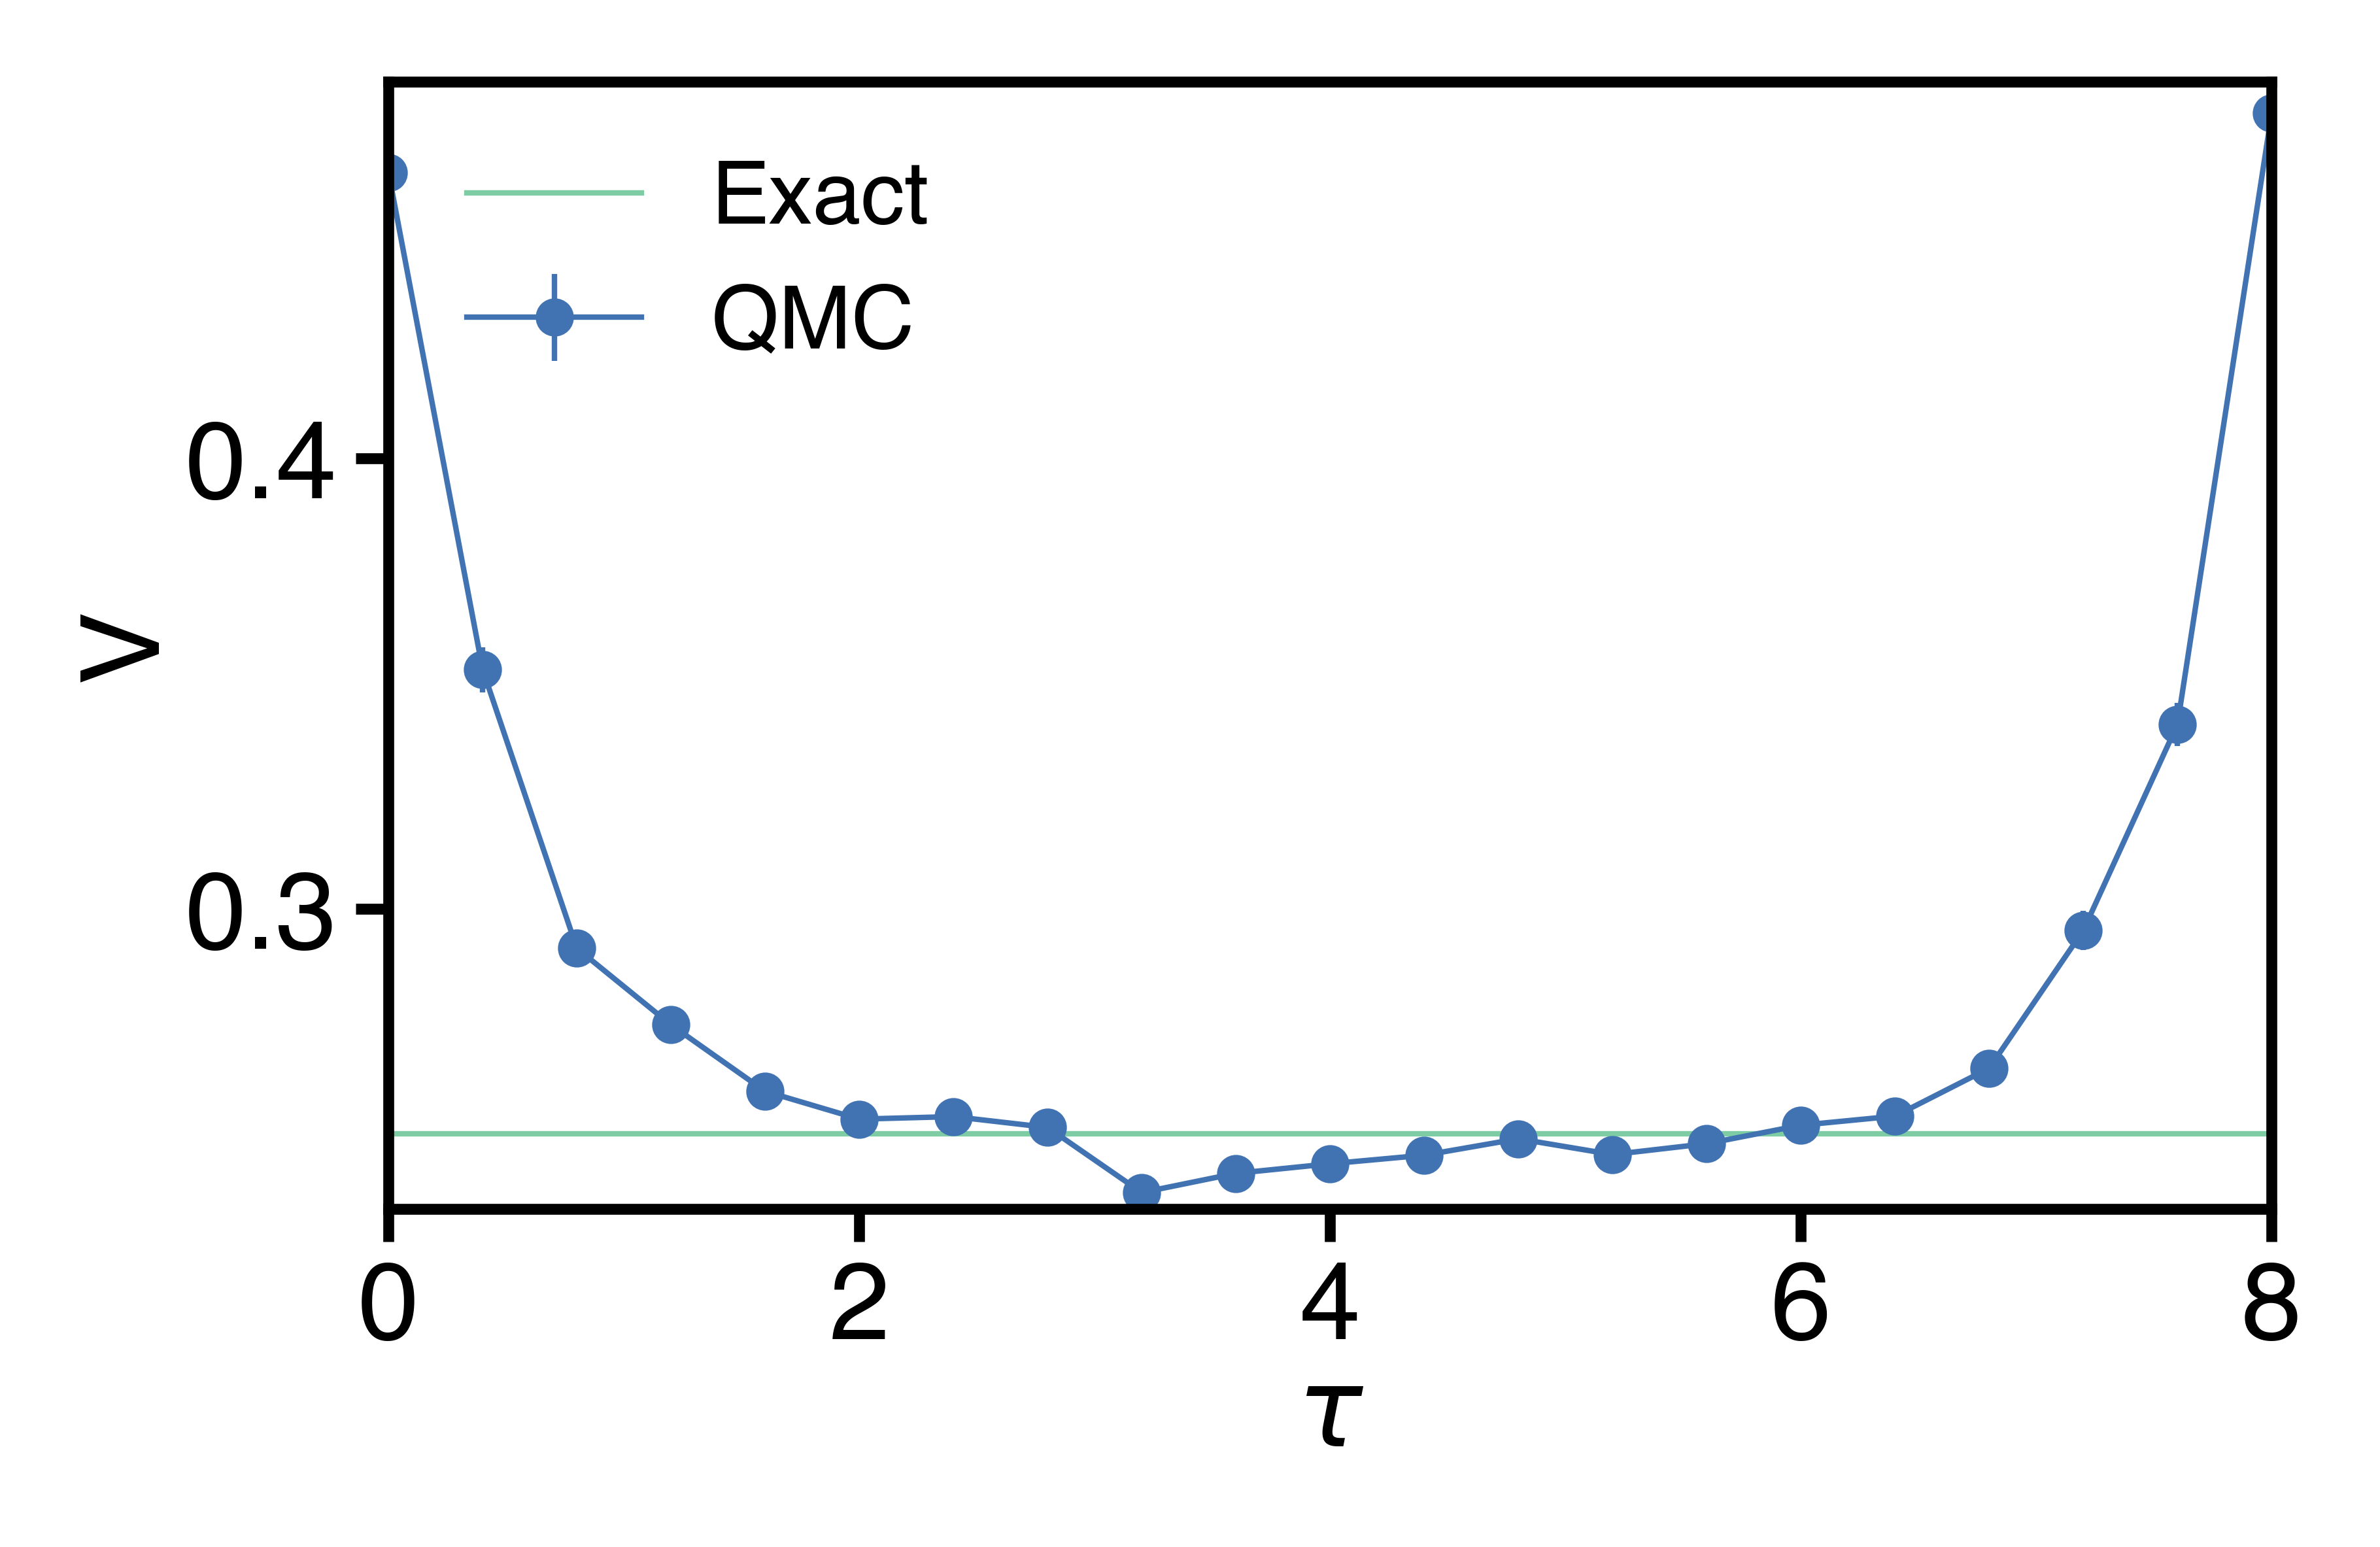

In [24]:
plt.axhline(y=0.25, color=green, linewidth=1.0, label='Exact')
plt.errorbar(np.linspace(0,2*τ,2*M+1), V̄slice,yerr=ΔV̄slice, marker='o', color=blue, 
             linewidth=1.0, elinewidth=1.0, markersize=6, markerfacecolor=blue, markeredgecolor=blue, 
             ecolor=blue, label='QMC')
plt.xlabel(r'$\tau$')
plt.ylabel('V')
plt.legend(loc='upper left');